In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

2024-07-21 22:44:08.573582: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 22:44:08.585578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 22:44:08.598878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 22:44:08.602354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 22:44:08.612547: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dict_gender = {
    0: 'male',
    1: 'female'
}
dict_race = {
    0: 'white',
    1: 'black',
    2: 'asian',
    3: 'indian',
    4: 'others'
}

dict_age = {
    0: 'child',
    1: 'teenager',
    2: 'adult',
    3: 'old',
}

In [3]:
def load_data(directory):
    dict_data = {
        'image': [],
        'age': [],
        'gender': [],
        'race': [],
    }
    for file in os.listdir(directory):
        label = file.split('_')
        dict_data['image'].append(directory + '/'+file)
        dict_data['age'].append(int(label[0]))
        dict_data['gender'].append(int(label[1]))
        dict_data['race'].append(int(label[2]))
    
    df_data = pd.DataFrame(dict_data)
    return df_data


In [4]:
df_data = load_data('data/UTKFace')
df_data_2 = load_data('data/FairFace')

In [5]:
df_data.head()

,image,age,gender,race
0,data/UTKFace/1_0_0_20161219200139603.jpg.chip.jpg,1,0,0
1,data/UTKFace/1_0_0_20161219200250923.jpg.chip.jpg,1,0,0
2,data/UTKFace/1_0_0_20161219200338012.jpg.chip.jpg,1,0,0
3,data/UTKFace/1_0_0_20161219202455708.jpg.chip.jpg,1,0,0
4,data/UTKFace/1_0_0_20161219203009924.jpg.chip.jpg,1,0,0


In [6]:
bins = [0, 12, 18, 49, 116]
labels = [0, 1, 2, 3]
df_data['age'] = pd.cut(df_data['age'], bins=bins, labels=labels)

In [7]:
df_data

,image,age,gender,race
0,data/UTKFace/1_0_0_20161219200139603.jpg.chip.jpg,0,0,0
1,data/UTKFace/1_0_0_20161219200250923.jpg.chip.jpg,0,0,0
2,data/UTKFace/1_0_0_20161219200338012.jpg.chip.jpg,0,0,0
3,data/UTKFace/1_0_0_20161219202455708.jpg.chip.jpg,0,0,0
4,data/UTKFace/1_0_0_20161219203009924.jpg.chip.jpg,0,0,0
...,...,...,...,...
23700,data/UTKFace/63_1_0_20170117163639729.jpg.chip...,3,1,0
23701,data/UTKFace/63_1_0_20170117175251077.jpg.chip...,3,1,0
23702,data/UTKFace/63_1_0_20170117175354308.jpg.chip...,3,1,0
23703,data/UTKFace/63_1_0_20170117175356028.jpg.chip...,3,1,0


In [8]:
df_data_2 = df_data_2[((df_data_2['age'] == 1) | (df_data_2['age'] == 3)) & ((df_data_2['race'] == 3) | (df_data_2['race'] == 4))]
df_data_2.reset_index(drop=True, inplace=True)

In [9]:
df_data_2

,image,age,gender,race
0,data/FairFace/3_0_3_14869.jpg,3,0,3
1,data/FairFace/3_0_3_15281.jpg,3,0,3
2,data/FairFace/3_0_3_15410.jpg,3,0,3
3,data/FairFace/3_0_3_1558.jpg,3,0,3
4,data/FairFace/3_0_3_15592.jpg,3,0,3
...,...,...,...,...
9468,data/FairFace/3_0_3_10274.jpg,3,0,3
9469,data/FairFace/3_0_3_10320.jpg,3,0,3
9470,data/FairFace/3_0_3_10418.jpg,3,0,3
9471,data/FairFace/3_0_3_1046.jpg,3,0,3


In [10]:
df_data = pd.concat([df_data, df_data_2], axis=0).reset_index(drop=True)

In [11]:
def plot_each_label(df):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    df['age'].value_counts().plot(kind='bar', ax=ax[0]).set_title('Age')
    df['gender'].value_counts().plot(kind='bar', ax=ax[1]).set_title('Gender')
    df['race'].value_counts().plot(kind='bar', ax=ax[2]).set_title('Race')
    plt.show()

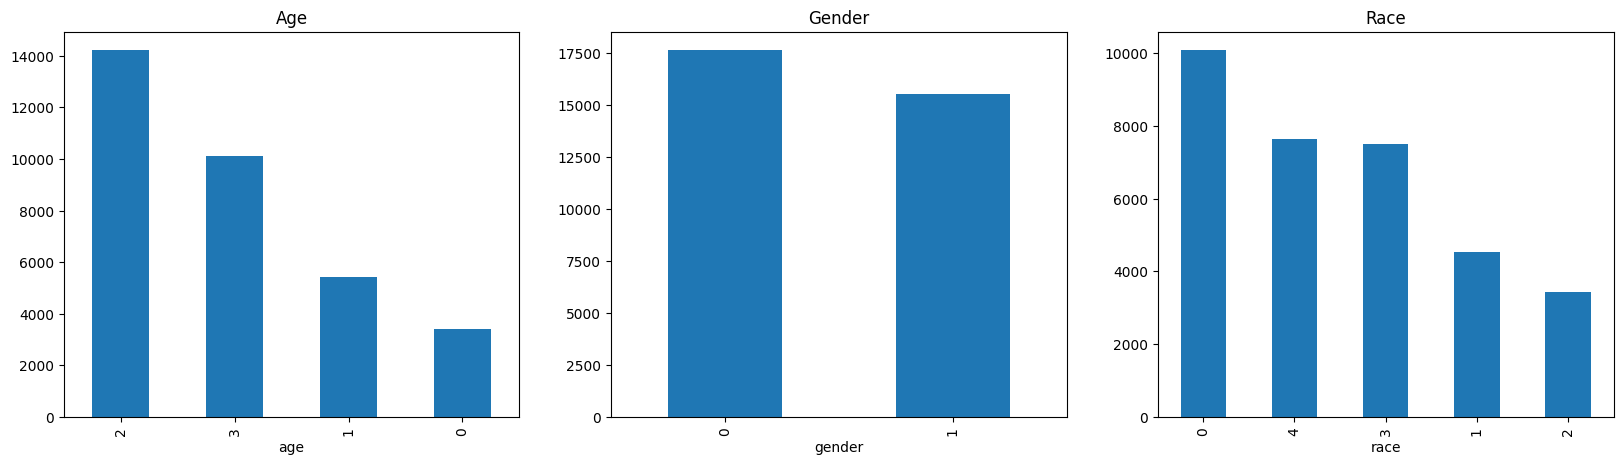

In [12]:
plot_each_label(df_data)

In [13]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(unique_labels)), counts)
    plt.ylabel('Labels')
    plt.xlabel('Count')
    plt.title('Label Distribution')
    plt.yticks(range(len(unique_labels)), [f'{dict_age[label[0]]} {dict_gender[label[1]]} {dict_race[label[2]]} {label}' for label in unique_labels], fontsize=8)
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(int(v)), va='center', fontsize=8)
    plt.show()

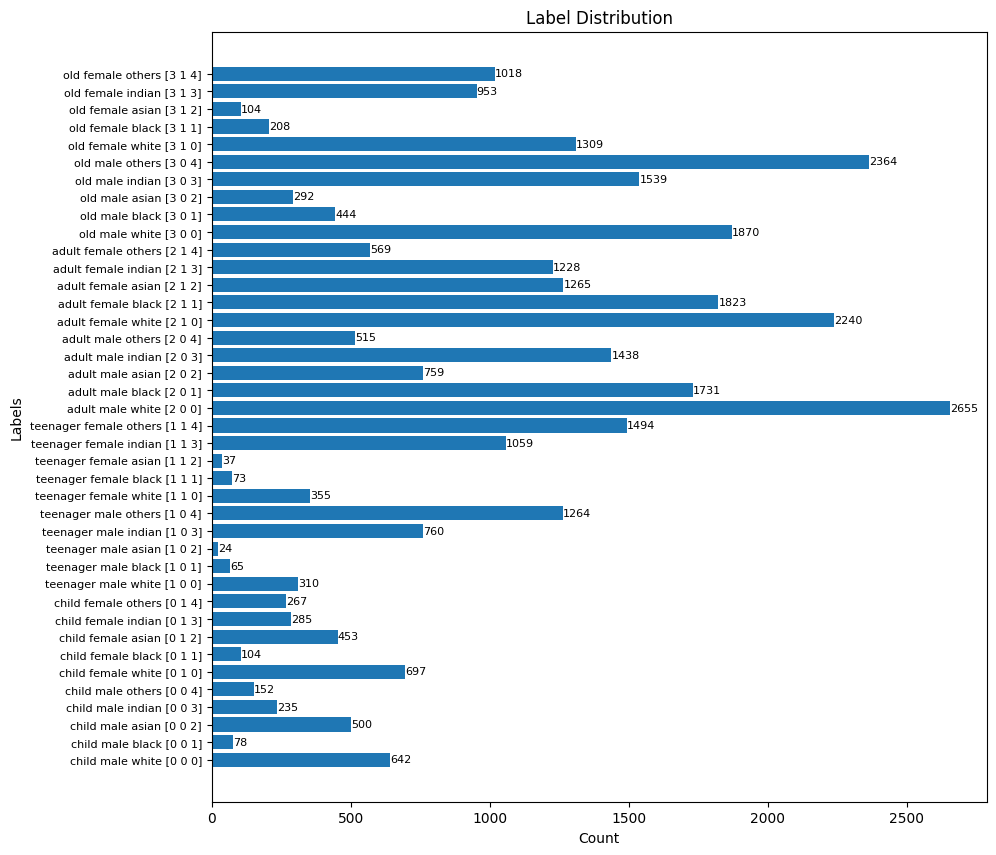

In [14]:
plot_label_distribution(df_data[['age','gender', 'race']])

In [15]:
def load_single_image(df, i):
    image = cv2.imread((df['image'][i]),cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(150, 150))
    label = [df['age'][i],df['gender'][i],df['race'][i]]
    return np.array(image, np.uint8), np.array(label, np.uint8)

def load_image(df):
    images = []
    labels = []
    with ThreadPoolExecutor(max_workers=12) as executor:
        for i in range(len(df)):
            image, label = executor.submit(load_single_image, df, i).result()
            images.append(image)
            labels.append(label)
    return np.array(images, np.uint8), np.array(labels, np.uint8)

In [16]:
images, labels = load_image(df_data)
images.shape, labels.shape

((33178, 150, 150, 3), (33178, 3))

In [17]:
del df_data

In [18]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index])
        axes[i].set_title(f'{dict_age[labels[index][0]]}, {dict_gender[labels[index][1]]}, {dict_race[labels[index][2]]}', fontsize=8)
        axes[i].axis('off')
    plt.show()

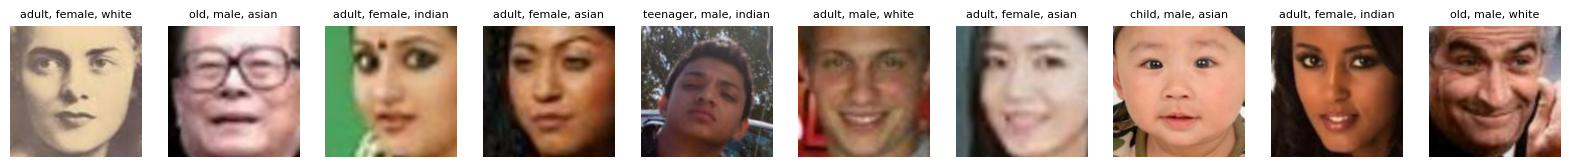

In [19]:
show_sample_images(images, labels)

In [20]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

In [21]:
# images, labels = downsample(images, labels, 1900)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [23]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.9, 1.1),
        shear_range=0.1,
        channel_shift_range=0.1,
        fill_mode='nearest',
    )

    for i in range(num_augmentations):
        augmented_images.extend(next(data_augmentation.flow(images, batch_size=len(images), shuffle=False)))
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, np.uint8)
    augmented_labels = np.array(augmented_labels, np.uint8)
        
    return augmented_images, augmented_labels

In [24]:
# augmentation_params = [
#     ([3, 1, 4], 2),
#     ([3, 1, 3], 2),
#     # ([3, 1, 2], 10),
#     # ([3, 1, 1], 6),
#     # ([3, 0, 4], 1),
#     # ([3, 0, 3], 1),
#     # ([3, 0, 2], 6),
#     # ([3, 0, 1], 3),
#     # ([2, 1, 4], 2),
#     # ([2, 1, 3], 1),
#     # ([2, 1, 2], 1),
#     # ([2, 0, 4], 2),
#     # ([2, 0, 3], 1),
#     # ([2, 0, 2], 3),
#     # ([1, 1, 4], 10),
#     # ([1, 1, 3], 10),
#     # ([1, 1, 2], 10),
#     # ([1, 1, 1], 10),
#     # ([1, 1, 0], 10),
#     # ([1, 0, 4], 10),
#     # ([1, 0, 3], 10),
#     # ([1, 0, 2], 10),
#     # ([1, 0, 1], 10),
#     # ([1, 0, 0], 10),
#     # ([0, 1, 4], 10),
#     # ([0, 1, 3], 9),
#     # ([0, 1, 2], 4),
#     # ([0, 1, 1], 10),
#     # ([0, 1, 0], 3),
#     # ([0, 0, 4], 10),
#     # ([0, 0, 3], 10),
#     # ([0, 0, 2], 4),
#     # ([0, 0, 1], 10),
#     # ([0, 0, 0], 3),
# ]


# batch_size = 128
# for target_label, num_augmentations in augmentation_params:
#     target_indices = [i for i, label in enumerate(y_train) if np.all(label == target_label)]
#     for i in range(0, len(target_indices), batch_size):
#         batch_indices = target_indices[i:i+batch_size]
#         target_images = x_train[batch_indices]
#         target_labels = y_train[batch_indices]
#         augmented_images, augmented_labels = image_augmentation(target_images, target_labels, num_augmentations)
        
#         x_train = np.concatenate((x_train, augmented_images), axis=0)
#         y_train = np.concatenate((y_train, augmented_labels), axis=0)
#     print(f'Augmentation for {target_label} done')

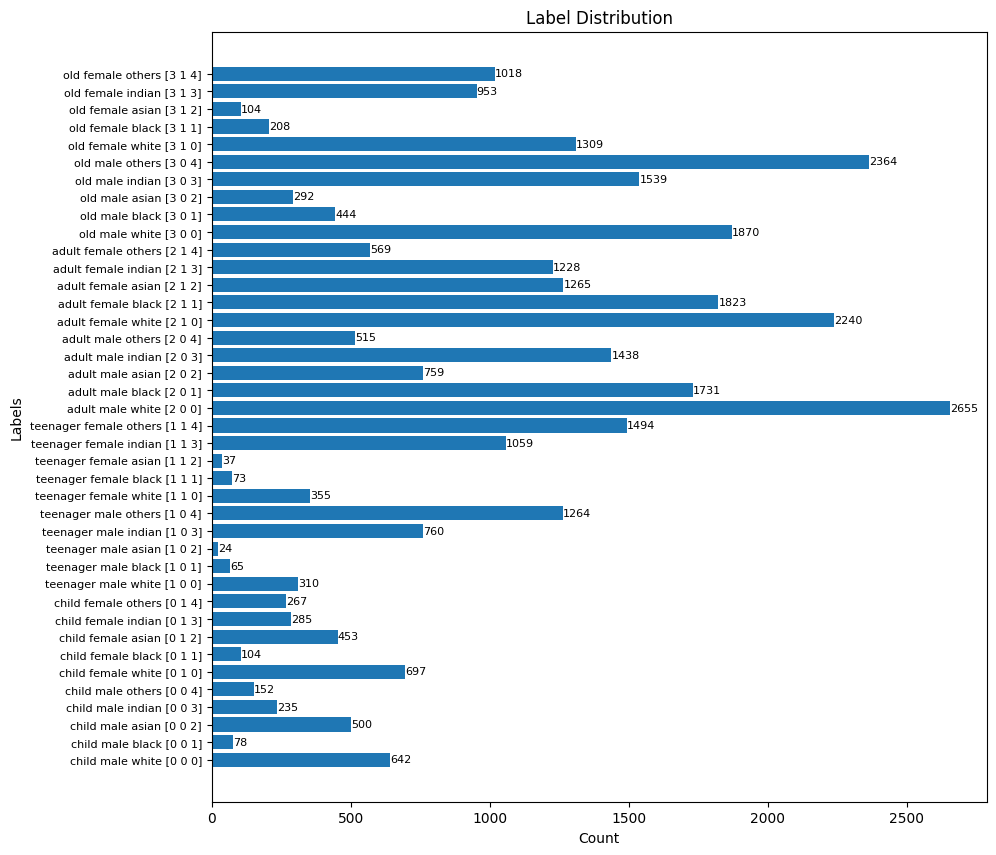

In [25]:
plot_label_distribution(np.concatenate((y_train, y_test), axis=0))

In [26]:
y_train_1, y_train_2, y_train_3 = y_train[:,0], y_train[:,1], y_train[:,2]
y_test_1, y_test_2, y_test_3 = y_test[:,0], y_test[:,1], y_test[:,2]

In [27]:
with tf.device('/cpu:0'):
    x_train = tf.convert_to_tensor(x_train)
    x_test = tf.convert_to_tensor(x_test)
    y_train_1 = to_categorical(y_train_1)
    y_train_2 = tf.convert_to_tensor(y_train_2)
    y_train_3 = to_categorical(y_train_3)
    y_test_1 = to_categorical(y_test_1)
    y_test_2 = tf.convert_to_tensor(y_test_2)
    y_test_3 = to_categorical(y_test_3)

I0000 00:00:1721573067.488057   38965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721573067.570103   38965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721573067.570744   38965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721573067.573707   38965 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [28]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
outputs_1 = tf.keras.layers.Dense(4, activation='softmax', name='age')(dense_1)

dense_2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_2 = tf.keras.layers.Dropout(0.2)(dense_2)
outputs_2 = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_2)

dense_3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_3 = tf.keras.layers.Dropout(0.2)(dense_3)
outputs_3 = tf.keras.layers.Dense(5, activation='softmax', name='race')(dense_3)

model = tf.keras.models.Model(inputs=inputs, outputs=[outputs_1, outputs_2, outputs_3])
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy', 'binary_crossentropy', 'categorical_crossentropy'], 
              metrics=['accuracy', 'accuracy', 'accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 18, 18,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 18, 18,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 9, 9, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20736)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20736)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,654,336 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  2,654,336 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,654,336 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 4)         │        516 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race (Dense)        │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 8,352,714 (31.86 MB)

 Trainable params: 8,352,714 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

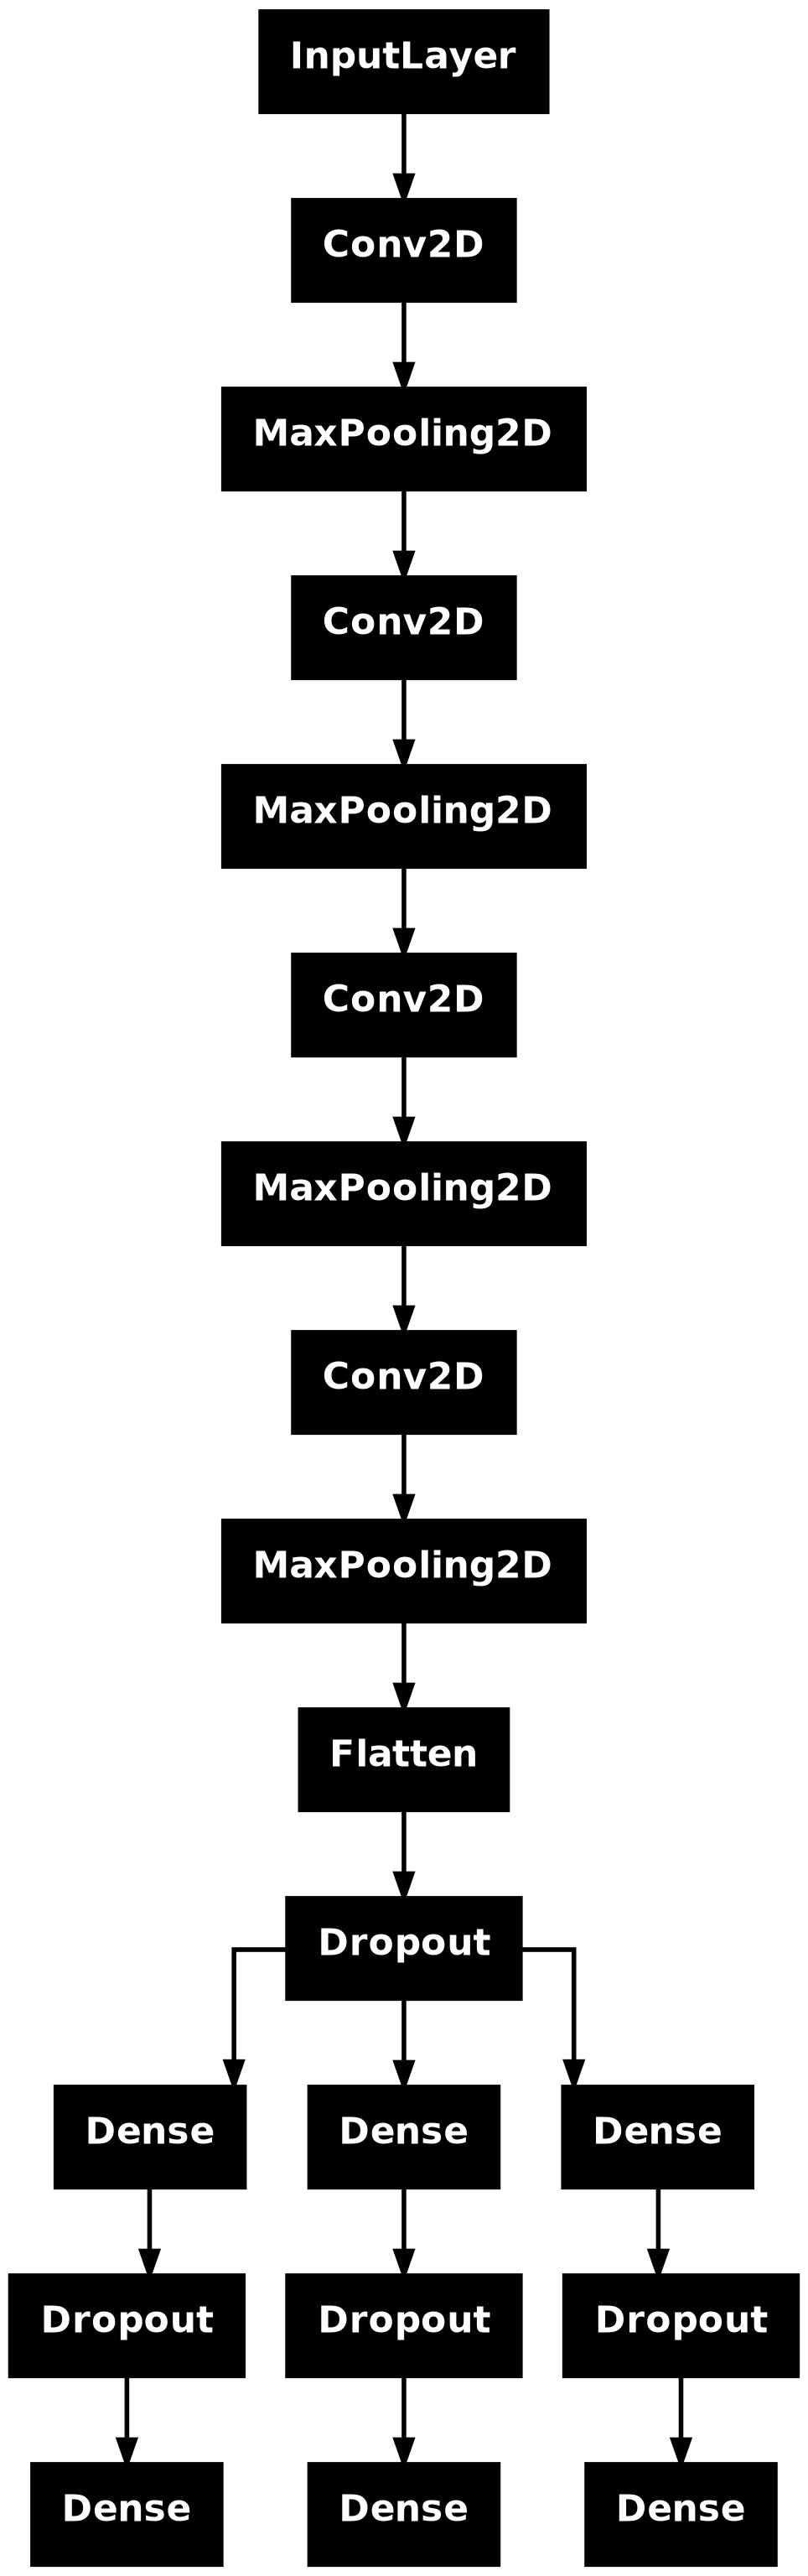

In [29]:
plot_model(model)

In [30]:
history = model.fit(x_train, [y_train_1, y_train_2, y_train_3], validation_data=(x_test, [y_test_1, y_test_2, y_test_3]), epochs=50, batch_size=64)

Epoch 1/50


I0000 00:00:1721573072.751801   39121 service.cc:146] XLA service 0x7cde78006a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721573072.751840   39121 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-07-21 22:44:32.817348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 22:44:33.320502: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-21 22:44:34.315436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 4 bytes spill stores, 4 bytes spill loads

2024-07-21 22:44:34.638768: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in 

  2/415 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - age_accuracy: 0.3516 - gender_accuracy: 0.4727 - loss: 81.7952 - race_accuracy: 0.2461   

I0000 00:00:1721573093.946105   39121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/415 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - age_accuracy: 0.5119 - gender_accuracy: 0.6555 - loss: 9.3019 - race_accuracy: 0.3895

2024-07-21 22:45:26.504298: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 16 bytes spill stores, 16 bytes spill loads

2024-07-21 22:45:27.211544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-07-21 22:45:27.740603: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 160 bytes spill stores, 160 bytes spill loads

2024-07-21 22:45:28.682920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 180 bytes spill stores, 180 bytes spill loads

2024-07-21 22:45:29.167732: I external/local_xla/xla/stream_executor/c

415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - age_accuracy: 0.5121 - gender_accuracy: 0.6557 - loss: 9.2906 - race_accuracy: 0.3897

2024-07-21 22:45:44.845696: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 144 bytes spill stores, 144 bytes spill loads

2024-07-21 22:45:52.267980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 4 bytes spill stores, 4 bytes spill loads

2024-07-21 22:45:52.547715: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 160 bytes spill stores, 160 bytes spill loads



415/415 ━━━━━━━━━━━━━━━━━━━━ 87s 151ms/step - age_accuracy: 0.5123 - gender_accuracy: 0.6558 - loss: 9.2793 - race_accuracy: 0.3899 - val_age_accuracy: 0.7401 - val_gender_accuracy: 0.8080 - val_loss: 2.8406 - val_race_accuracy: 0.6138
Epoch 2/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - age_accuracy: 0.7158 - gender_accuracy: 0.7928 - loss: 2.9387 - race_accuracy: 0.5950 - val_age_accuracy: 0.7958 - val_gender_accuracy: 0.8412 - val_loss: 2.4317 - val_race_accuracy: 0.6807
Epoch 3/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - age_accuracy: 0.7581 - gender_accuracy: 0.8112 - loss: 2.5924 - race_accuracy: 0.6452 - val_age_accuracy: 0.8046 - val_gender_accuracy: 0.8517 - val_loss: 2.1978 - val_race_accuracy: 0.7123
Epoch 4/50
415/415 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - age_accuracy: 0.7949 - gender_accuracy: 0.8282 - loss: 2.3524 - race_accuracy: 0.6810 - val_age_accuracy: 0.8229 - val_gender_accuracy: 0.8580 - val_loss: 2.1121 - val_race_accuracy: 0.7346
Epoch 5/50
415/415 ━━━━━━━

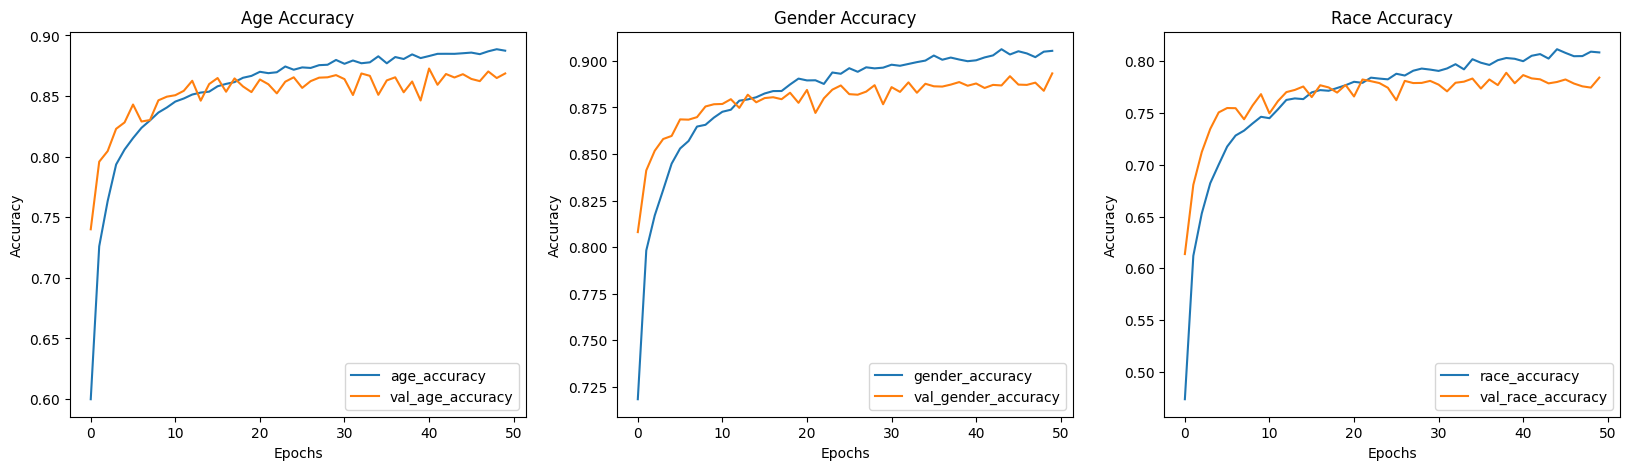

In [31]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['age_accuracy'], label='age_accuracy')
plt.plot(history.history['val_age_accuracy'], label='val_age_accuracy')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['gender_accuracy'], label='gender_accuracy')
plt.plot(history.history['val_gender_accuracy'], label='val_gender_accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['race_accuracy'], label='race_accuracy')
plt.plot(history.history['val_race_accuracy'], label='val_race_accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [32]:
y_pred = model.predict(x_test)

2024-07-21 23:13:32.662950: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 8 bytes spill stores, 8 bytes spill loads

2024-07-21 23:13:33.473956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 144 bytes spill stores, 144 bytes spill loads

2024-07-21 23:13:33.555726: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 20 bytes spill stores, 20 bytes spill loads



208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step


In [33]:
print(y_pred[0].shape, y_pred[1].shape, y_pred[2].shape)
print(y_test_1.shape, y_test_2.shape, y_test_3.shape)

(6636, 4) (6636, 1) (6636, 5)
(6636, 4) (6636,) (6636, 5)


In [34]:
y_pred_age = np.argmax(y_pred[0], axis=1)
y_pred_gender = np.round(y_pred[1])
y_pred_race = np.argmax(y_pred[2], axis=1)

y_test_1 = np.argmax(y_test_1, axis=1)
y_test_2 = y_test_2
y_test_3 = np.argmax(y_test_3, axis=1)

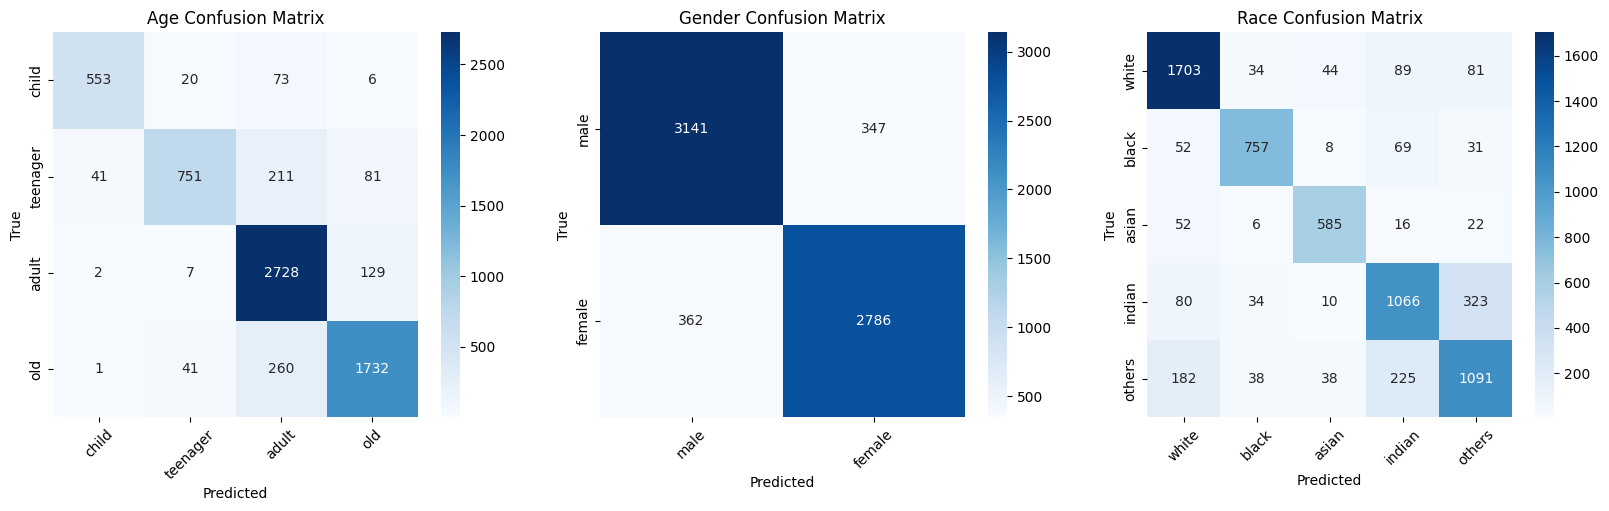

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test_1, y_pred_age), annot=True, fmt='d', cmap='Blues', xticklabels=dict_age.values(), yticklabels=dict_age.values())
plt.title('Age Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test_2, y_pred_gender), annot=True, fmt='d', cmap='Blues', xticklabels=dict_gender.values(), yticklabels=dict_gender.values())
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test_3, y_pred_race), annot=True, fmt='d', cmap='Blues', xticklabels=dict_race.values(), yticklabels=dict_race.values())
plt.title('Race Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.show()

In [36]:
print(classification_report(y_test_1, y_pred_age, target_names=dict_age.values()))

              precision    recall  f1-score   support

       child       0.93      0.85      0.89       652
    teenager       0.92      0.69      0.79      1084
       adult       0.83      0.95      0.89      2866
         old       0.89      0.85      0.87      2034

    accuracy                           0.87      6636
   macro avg       0.89      0.84      0.86      6636
weighted avg       0.87      0.87      0.87      6636



In [37]:
print(classification_report(y_test_2, y_pred_gender, target_names=dict_gender.values()))

              precision    recall  f1-score   support

        male       0.90      0.90      0.90      3488
      female       0.89      0.89      0.89      3148

    accuracy                           0.89      6636
   macro avg       0.89      0.89      0.89      6636
weighted avg       0.89      0.89      0.89      6636



In [38]:
print(classification_report(y_test_3, y_pred_race, target_names=dict_race.values()))

              precision    recall  f1-score   support

       white       0.82      0.87      0.85      1951
       black       0.87      0.83      0.85       917
       asian       0.85      0.86      0.86       681
      indian       0.73      0.70      0.72      1513
      others       0.70      0.69      0.70      1574

    accuracy                           0.78      6636
   macro avg       0.80      0.79      0.79      6636
weighted avg       0.78      0.78      0.78      6636



In [39]:
# model.save('model_age_gender_race.h5')

In [40]:
# model.save_weights('checkpoint/cp_1.ckpt')